# Machine Learning

---

This notebook is for the machine learning of our dataset.

Here is our problem definition:

> (1) To predict if a customer will have a claim on their insurance policy.         
> (2) To predict the claim cost for customers with claim(s).
---

### Preparation

First, we will import the necessary libraries that will be used in this notebook


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PoissonRegressor
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso

---
The cleaned data is imported as a DataFrame named `data`.



In [3]:
data = pd.read_csv("Prepped.csv")
data.head()

,pol_eff_dt,gender,agecat,credit_score,area,traffic_index,veh_age,veh_body,veh_value,numclaims,claimcst0,month,year,monthDiff,claims
0,12/30/2020,F,4.0,4.265979,D,65.811441,34.0,HBACK,1.331,0,0.0,12.0,2020.0,40.0,No
1,12/30/2020,F,2.0,38.558763,D,81.542373,1.0,UTE,3.740,0,0.0,12.0,2020.0,40.0,No
2,12/30/2020,M,2.0,58.971134,B,57.369174,100.0,COUPE,0.880,0,0.0,12.0,2020.0,40.0,No
3,12/30/2020,M,4.0,78.158763,B,48.559852,67.0,SEDAN,1.045,0,0.0,12.0,2020.0,40.0,No
4,12/30/2020,F,4.0,93.263918,C,56.320445,100.0,HBACK,0.473,0,0.0,12.0,2020.0,40.0,No


---
For our first problem, we will be using Binary Classification techniques to predict if a claim will be raised by a customer.

Response variable: `claims`

Before we perform classification, we will use `OneHotEncoding` to convert the categorical data to numerical data.

In [3]:
ohe = OneHotEncoder()

data_cat = data[["gender", "agecat", "area", "veh_body"]]
ohe.fit(data_cat)
data_cat_ohe = pd.DataFrame(ohe.transform(data_cat).toarray(),
                           columns = ohe.get_feature_names_out(data_cat.columns))
data_cat_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54135 entries, 0 to 54134
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender_F        54135 non-null  float64
 1   gender_M        54135 non-null  float64
 2   agecat_1.0      54135 non-null  float64
 3   agecat_2.0      54135 non-null  float64
 4   agecat_3.0      54135 non-null  float64
 5   agecat_4.0      54135 non-null  float64
 6   agecat_5.0      54135 non-null  float64
 7   agecat_6.0      54135 non-null  float64
 8   area_A          54135 non-null  float64
 9   area_B          54135 non-null  float64
 10  area_C          54135 non-null  float64
 11  area_D          54135 non-null  float64
 12  area_E          54135 non-null  float64
 13  area_F          54135 non-null  float64
 14  veh_body_BUS    54135 non-null  float64
 15  veh_body_CONVT  54135 non-null  float64
 16  veh_body_COUPE  54135 non-null  float64
 17  veh_body_HBACK  54135 non-null 

In [27]:
data_num = data[["credit_score", "traffic_index", "veh_age", "monthDiff"]]
data_res = data["claims"]
dataOHE = pd.concat([data_cat_ohe, data_num, data_res],
                   sort = False, axis = 1).reindex(index = data_num.index)

dataOHE.head()

,gender_F,gender_M,agecat_1.0,agecat_2.0,agecat_3.0,agecat_4.0,agecat_5.0,agecat_6.0,area_A,area_B,...,veh_body_RDSTR,veh_body_SEDAN,veh_body_STNWG,veh_body_TRUCK,veh_body_UTE,credit_score,traffic_index,veh_age,monthDiff,claims
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.265979,65.811441,34.0,40.0,No
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,38.558763,81.542373,1.0,40.0,No
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,58.971134,57.369174,100.0,40.0,No
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,78.158763,48.559852,67.0,40.0,No
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,93.263918,56.320445,100.0,40.0,No


There is also huge data imbalance for the response `claims`, as visualised below. As such, we need to upsample the "Yes" to match with "No"

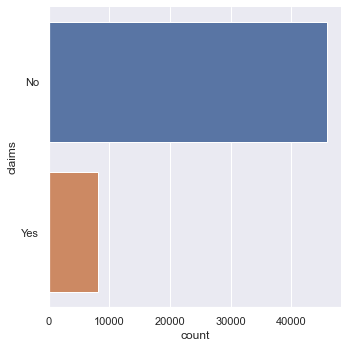

In [5]:
sb.catplot(y = "claims", data = dataOHE, kind = "count")

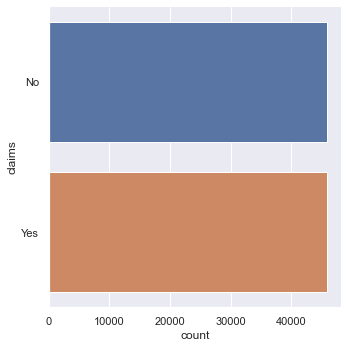

In [29]:
claimsNo = dataOHE[dataOHE.claims == "No"]
claimsYes = dataOHE[dataOHE.claims == "Yes"]

claimsYes_up = resample(claimsYes,
                      replace = True,
                      n_samples = claimsNo.shape[0])

dataOHE_up = pd.concat([claimsNo, claimsYes_up])

sb.catplot(y = "claims", data = dataOHE_up, kind = "count")

In [30]:
dataOHE_up.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91926 entries, 0 to 17848
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender_F        91926 non-null  float64
 1   gender_M        91926 non-null  float64
 2   agecat_1.0      91926 non-null  float64
 3   agecat_2.0      91926 non-null  float64
 4   agecat_3.0      91926 non-null  float64
 5   agecat_4.0      91926 non-null  float64
 6   agecat_5.0      91926 non-null  float64
 7   agecat_6.0      91926 non-null  float64
 8   area_A          91926 non-null  float64
 9   area_B          91926 non-null  float64
 10  area_C          91926 non-null  float64
 11  area_D          91926 non-null  float64
 12  area_E          91926 non-null  float64
 13  area_F          91926 non-null  float64
 14  veh_body_BUS    91926 non-null  float64
 15  veh_body_CONVT  91926 non-null  float64
 16  veh_body_COUPE  91926 non-null  float64
 17  veh_body_HBACK  91926 non-null 

Now, we will perform `LogisticRegression` to predict the response `claims`.

We will split the dataset into train and test dataset, with test size being 30%.

In [31]:
y = pd.DataFrame(dataOHE_up["claims"])
x = pd.DataFrame(dataOHE_up.drop("claims", axis = 1))

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3)

logreg = LogisticRegression(max_iter = 400)

logreg.fit(xTrain, yTrain.claims.ravel())

/Users/limjunyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=400)

Train data
Accuracy :	 0.7347081494374339

TPR :	 0.735569929745288
TNR :	 0.7338389986578019

FPR :	 0.26616100134219806
FNR :	 0.264430070254712


<AxesSubplot:>

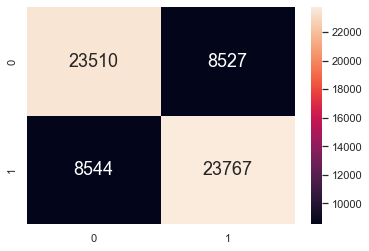

In [32]:
yTrain_pred = logreg.predict(xTrain)

print("Train data")
print("Accuracy :\t", logreg.score(xTrain, yTrain))
print()

cmTrain = confusion_matrix(yTrain, yTrain_pred)
tnTrain = cmTrain[0][0]
fpTrain = cmTrain[0][1]
fnTrain = cmTrain[1][0]
tpTrain = cmTrain[1][1]

print("TPR :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR :\t", (tnTrain/(tnTrain + fpTrain)))
print()
print("FPR :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR :\t", (fnTrain/(tpTrain + fnTrain)))

sb.heatmap(cmTrain, annot = True, fmt = ".0f", annot_kws = {"size":18})

Test data
Accuracy :	 0.7374718978896222

TPR :	 0.7424553179021389
TNR :	 0.7325865287950596

FPR :	 0.2674134712049404
FNR :	 0.25754468209786113


<AxesSubplot:>

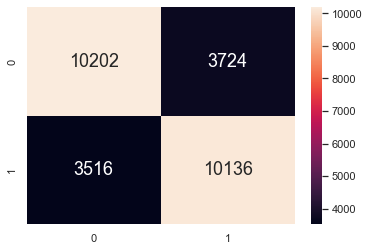

In [33]:
yTest_pred = logreg.predict(xTest)

print("Test data")
print("Accuracy :\t", logreg.score(xTest, yTest))
print()

cmTest = confusion_matrix(yTest, yTest_pred)
tnTest = cmTest[0][0]
fpTest = cmTest[0][1]
fnTest = cmTest[1][0]
tpTest = cmTest[1][1]

print("TPR :\t", (tpTest/(tpTest + fnTest)))
print("TNR :\t", (tnTest/(tnTest + fpTest)))
print()
print("FPR :\t", (fpTest/(fpTest + tnTest)))
print("FNR :\t", (fnTest/(fnTest + tpTest)))

sb.heatmap(cmTest, annot = True, fmt = ".0f", annot_kws = {"size":18})

A confusion matrix is plotted, with the accuracy metrics printed for the machine learning model.

---

`GridSearchCV` is used to find the best parameters to use for `LogisticRegression`

In [11]:
y = pd.DataFrame(dataOHE_up["claims"])
x = pd.DataFrame(dataOHE_up.drop("claims", axis = 1))

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3)

solver_list = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
params = dict(solver = solver_list)
log_reg = LogisticRegression(C = 1, n_jobs = -1, random_state = 34)
clf = GridSearchCV(log_reg, params, cv = 5)
clf.fit(xTrain, yTrain)
scores = clf.cv_results_['mean_test_score']

for score, solver in zip(scores, solver_list):
    print(f"{solver}:\t\t {score:.3f}" )


/Users/limjunyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/limjunyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/limjunyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/limjunyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn

/Users/limjunyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/limjunyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/limjunyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/limjunyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/limjunyu/opt/anaconda3/lib/python3.9/site-packa

liblinear:		 0.736
newton-cg:		 0.736
lbfgs:		 0.736
sag:		 0.736
saga:		 0.736


/Users/limjunyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


From `GridSearchCV` results, each solver for `LogisticRegression` yields the same result.

---

Next, we will try a new machine learning model to predict the response.
`RandomForestClassifier` will be used.

In [34]:
y = pd.DataFrame(dataOHE_up["claims"])
x = pd.DataFrame(dataOHE_up.drop("claims", axis = 1))

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3)

rforest = RandomForestClassifier(n_estimators = 100,
                                 max_depth = 10)

rforest.fit(xTrain, yTrain.claims.ravel())

RandomForestClassifier(max_depth=10)

Train data
Accuracy :	 0.772766830359918

TPR :	 0.784288154013352
TNR :	 0.7612232834520736

FPR :	 0.23877671654792645
FNR :	 0.21571184598664803


<AxesSubplot:>

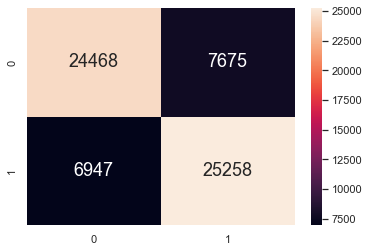

In [35]:
yTrain_pred = rforest.predict(xTrain)

print("Train data")
print("Accuracy :\t", rforest.score(xTrain, yTrain))
print()

cmTrain = confusion_matrix(yTrain, yTrain_pred)
tnTrain = cmTrain[0][0]
fpTrain = cmTrain[0][1]
fnTrain = cmTrain[1][0]
tpTrain = cmTrain[1][1]

print("TPR :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR :\t", (tnTrain/(tnTrain + fpTrain)))
print()
print("FPR :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR :\t", (fnTrain/(tpTrain + fnTrain)))

sb.heatmap(cmTrain, annot = True, fmt = ".0f", annot_kws = {"size":18})

Test data
Accuracy :	 0.7634346217999854

TPR :	 0.7746038668411106
TNR :	 0.752315484804631

FPR :	 0.24768451519536902
FNR :	 0.22539613315888937


<AxesSubplot:>

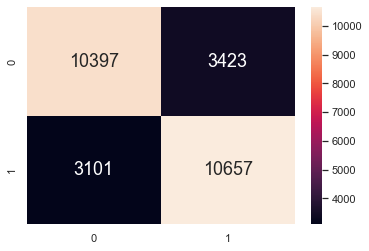

In [36]:
yTest_pred = rforest.predict(xTest)

print("Test data")
print("Accuracy :\t", rforest.score(xTest, yTest))
print()

cmTest = confusion_matrix(yTest, yTest_pred)
tnTest = cmTest[0][0]
fpTest = cmTest[0][1]
fnTest = cmTest[1][0]
tpTest = cmTest[1][1]

print("TPR :\t", (tpTest/(tpTest + fnTest)))
print("TNR :\t", (tnTest/(tnTest + fpTest)))
print()
print("FPR :\t", (fpTest/(fpTest + tnTest)))
print("FNR :\t", (fnTest/(fnTest + tpTest)))

sb.heatmap(cmTest, annot = True, fmt = ".0f", annot_kws = {"size":18})

In [15]:
y = pd.DataFrame(dataOHE_up["claims"])
x = pd.DataFrame(dataOHE_up.drop("claims", axis = 1))

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3)

param_grid = {'n_estimators': np.arange(100,1001,100),   
              'max_depth': np.arange(2, 11)}             

hpGrid = GridSearchCV(RandomForestClassifier(),   
                      param_grid,                 
                      cv = 5,                     
                      scoring = 'accuracy')       

hpGrid.fit(xTrain, yTrain.claims.ravel())
# print(hpGrid.best_estimator_)
# print(np.abs(hpGrid.best_score_))

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])},
             scoring='accuracy')

In [16]:
# Fetch the best Model or the best set of Hyper-parameters
print(hpGrid.best_estimator_)

# Print the score (accuracy) of the best Model after CV
print(np.abs(hpGrid.best_score_))

RandomForestClassifier(max_depth=10, n_estimators=600)
0.7575837757359243


In [37]:
y = pd.DataFrame(dataOHE_up["claims"])
x = pd.DataFrame(dataOHE_up.drop("claims", axis = 1))

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3)

rforest = RandomForestClassifier(n_estimators = 600,
                                 max_depth = 10)

rforest.fit(xTrain, yTrain.claims.ravel())

RandomForestClassifier(max_depth=10, n_estimators=600)

Train data
Accuracy :	 0.773574936283956

TPR :	 0.7795199801285435
TNR :	 0.7676176845773311

FPR :	 0.23238231542266888
FNR :	 0.22048001987145652


<AxesSubplot:>

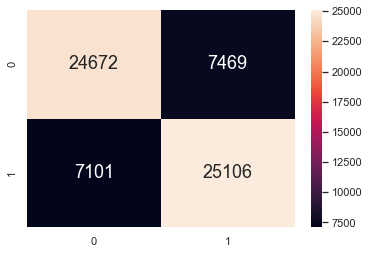

In [38]:
yTrain_pred = rforest.predict(xTrain)

print("Train data")
print("Accuracy :\t", rforest.score(xTrain, yTrain))
print()

cmTrain = confusion_matrix(yTrain, yTrain_pred)
tnTrain = cmTrain[0][0]
fpTrain = cmTrain[0][1]
fnTrain = cmTrain[1][0]
tpTrain = cmTrain[1][1]

print("TPR :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR :\t", (tnTrain/(tnTrain + fpTrain)))
print()
print("FPR :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR :\t", (fnTrain/(tpTrain + fnTrain)))

sb.heatmap(cmTrain, annot = True, fmt = ".0f", annot_kws = {"size":18})

Test data
Accuracy :	 0.7621654942345347

TPR :	 0.7737714451875545
TNR :	 0.750614961655332

FPR :	 0.2493850383446679
FNR :	 0.22622855481244547


<AxesSubplot:>

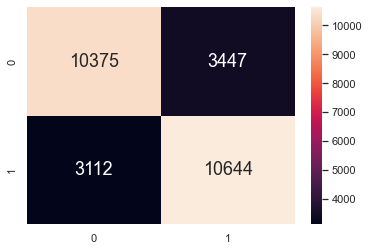

In [39]:
yTest_pred = rforest.predict(xTest)

print("Test data")
print("Accuracy :\t", rforest.score(xTest, yTest))
print()

cmTest = confusion_matrix(yTest, yTest_pred)
tnTest = cmTest[0][0]
fpTest = cmTest[0][1]
fnTest = cmTest[1][0]
tpTest = cmTest[1][1]

print("TPR :\t", (tpTest/(tpTest + fnTest)))
print("TNR :\t", (tnTest/(tnTest + fpTest)))
print()
print("FPR :\t", (fpTest/(fpTest + tnTest)))
print("FNR :\t", (fnTest/(fnTest + tpTest)))

sb.heatmap(cmTest, annot = True, fmt = ".0f", annot_kws = {"size":18})

---

For the second problem, we will be using regression techniques to predict the claim cost.

Before that, we will have to filter out only those rows where there is a claim.

In [4]:
data2 = data[data.numclaims > 0]
data2

,pol_eff_dt,gender,agecat,credit_score,area,traffic_index,veh_age,veh_body,veh_value,numclaims,claimcst0,month,year,monthDiff,claims
14,12/30/2020,M,5.0,45.703093,C,50.814619,67.0,SEDAN,1.5290,1,1120.833360,12.0,2020.0,40.0,Yes
17,12/30/2020,M,3.0,7.327835,E,9.127648,100.0,UTE,1.6500,2,4548.075015,12.0,2020.0,40.0,Yes
24,12/30/2020,M,2.0,65.707216,D,42.005297,67.0,TRUCK,3.3440,1,4657.070661,12.0,2020.0,40.0,Yes
27,12/30/2020,F,2.0,14.472165,C,53.960805,1.0,HBACK,2.4178,3,6616.971570,12.0,2020.0,40.0,Yes
32,12/30/2020,F,3.0,47.540206,D,52.964513,1.0,SEDAN,2.7500,1,4442.096621,12.0,2020.0,40.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54093,1/2/2020,M,4.0,16.921649,C,51.601165,100.0,HBACK,0.9350,1,804.425046,1.0,2020.0,39.0,Yes
54101,1/2/2020,F,3.0,65.707216,B,50.395127,100.0,SEDAN,1.1550,1,408.363278,1.0,2020.0,39.0,Yes
54116,1/2/2020,M,4.0,45.294845,C,64.972458,100.0,SEDAN,0.3850,1,490.897473,1.0,2020.0,39.0,Yes
54117,1/2/2020,M,1.0,51.010309,A,35.817797,67.0,HBACK,1.1220,1,402.791766,1.0,2020.0,39.0,Yes


In [5]:
data_lin = data2.copy()
data_lin.drop(["pol_eff_dt", "month", "year", "claims"], axis = 1)

,gender,agecat,credit_score,area,traffic_index,veh_age,veh_body,veh_value,numclaims,claimcst0,monthDiff
14,M,5.0,45.703093,C,50.814619,67.0,SEDAN,1.5290,1,1120.833360,40.0
17,M,3.0,7.327835,E,9.127648,100.0,UTE,1.6500,2,4548.075015,40.0
24,M,2.0,65.707216,D,42.005297,67.0,TRUCK,3.3440,1,4657.070661,40.0
27,F,2.0,14.472165,C,53.960805,1.0,HBACK,2.4178,3,6616.971570,40.0
32,F,3.0,47.540206,D,52.964513,1.0,SEDAN,2.7500,1,4442.096621,40.0
...,...,...,...,...,...,...,...,...,...,...,...
54093,M,4.0,16.921649,C,51.601165,100.0,HBACK,0.9350,1,804.425046,39.0
54101,F,3.0,65.707216,B,50.395127,100.0,SEDAN,1.1550,1,408.363278,39.0
54116,M,4.0,45.294845,C,64.972458,100.0,SEDAN,0.3850,1,490.897473,39.0
54117,M,1.0,51.010309,A,35.817797,67.0,HBACK,1.1220,1,402.791766,39.0


---

Similarly, we have to convert the categorical data to numerical.

This time, we used `DummyEncoding`.

The data is also split into train and test set, with test size being 30%.

We will be performing `LinearRegression`

In [436]:
# x = data[["gender", "agecat", "area", "veh_body", "credit_score", "traffic_index", "veh_age", "veh_body", "numclaims"]]
# x = pd.get_dummies(data = x, drop_first = True)
x = pd.DataFrame(data_lin.drop(["claimcst0"], axis = 1))
x = pd.get_dummies(data = x, drop_first = True)
y = pd.DataFrame(data_lin["claimcst0"])

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3)

linreg = LinearRegression()
linreg.fit(xTrain, yTrain)

LinearRegression()

In [437]:
yTrain_pred = linreg.predict(xTrain)
yTest_pred = linreg.predict(xTest)

print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(xTrain, yTrain))
print("Mean Squared Error (MSE) \t:", mean_squared_error(yTrain, yTrain_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(xTest, yTest))
print("Mean Squared Error (MSE) \t:", mean_squared_error(yTest, yTest_pred))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.9715623162221501
Mean Squared Error (MSE) 	: 967179.9051028119

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -9.842234758941654e+17
Mean Squared Error (MSE) 	: 2.6634073222959267e+25



In [438]:
x = pd.DataFrame(data_lin.drop(["claimcst0", "veh_value"], axis = 1))
x = pd.get_dummies(data = x, drop_first = True)
y = pd.DataFrame(data_lin["claimcst0"])

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3)

linreg = LinearRegression()
linreg.fit(xTrain, yTrain)

LinearRegression()

In [439]:
yTrain_pred = linreg.predict(xTrain)
yTest_pred = linreg.predict(xTest)

print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(xTrain, yTrain))
print("Mean Squared Error (MSE) \t:", mean_squared_error(yTrain, yTrain_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(xTest, yTest))
print("Mean Squared Error (MSE) \t:", mean_squared_error(yTest, yTest_pred))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.9731026119802697
Mean Squared Error (MSE) 	: 838628.8477831443

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -1.01833216655943e+16
Mean Squared Error (MSE) 	: 3.4304955532653414e+23



In [449]:
x = pd.DataFrame(data_lin.drop(["claimcst0", "veh_value", "veh_age"], axis = 1))
x = pd.get_dummies(data = x, drop_first = True)
y = pd.DataFrame(data_lin["claimcst0"])

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3)

linreg = LinearRegression()
linreg.fit(xTrain, yTrain)

LinearRegression()

In [441]:
yTrain_pred = linreg.predict(xTrain)
yTest_pred = linreg.predict(xTest)

print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(xTrain, yTrain))
print("Mean Squared Error (MSE) \t:", mean_squared_error(yTrain, yTrain_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(xTest, yTest))
print("Mean Squared Error (MSE) \t:", mean_squared_error(yTest, yTest_pred))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.9763423455714868
Mean Squared Error (MSE) 	: 715254.6780586382

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -0.6898495142629417
Mean Squared Error (MSE) 	: 60649412.78321482



In [460]:
x = pd.DataFrame(data_lin.drop(["claimcst0", "veh_value", "veh_age", "gender"], axis = 1))
x = pd.get_dummies(data = x, drop_first = True)
y = pd.DataFrame(data_lin["claimcst0"])

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3)

linreg = LinearRegression()
linreg.fit(xTrain, yTrain)

LinearRegression()

In [461]:
yTrain_pred = linreg.predict(xTrain)
yTest_pred = linreg.predict(xTest)

print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(xTrain, yTrain))
print("Mean Squared Error (MSE) \t:", mean_squared_error(yTrain, yTrain_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(xTest, yTest))
print("Mean Squared Error (MSE) \t:", mean_squared_error(yTest, yTest_pred))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.9704139753700755
Mean Squared Error (MSE) 	: 934884.1760800723

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -0.5223956880081411
Mean Squared Error (MSE) 	: 49792533.48301083



Lastly, we perform `RidgeRegression`

In [520]:
x = pd.DataFrame(data_lin.drop(["claimcst0", "veh_value", "gender"], axis = 1))
x = pd.get_dummies(data = x, drop_first = True)
y = pd.DataFrame(data_lin["claimcst0"])

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3)

ridgereg = Ridge(alpha = 5)

ridgereg.fit(xTrain, yTrain)

Ridge(alpha=5)

In [521]:
yTrain_pred = ridgereg.predict(xTrain)
yTest_pred = ridgereg.predict(xTest)

print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", ridgereg.score(xTrain, yTrain))
print("Mean Squared Error (MSE) \t:", mean_squared_error(yTrain, yTrain_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", ridgereg.score(xTest, yTest))
print("Mean Squared Error (MSE) \t:", mean_squared_error(yTest, yTest_pred))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.5747866440699785
Mean Squared Error (MSE) 	: 13338107.616857424

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.3442336847769233
Mean Squared Error (MSE) 	: 21787827.330715105



In [564]:
x = pd.DataFrame(data_lin.drop(["claimcst0", "veh_value", "gender"], axis = 1))
x = pd.get_dummies(data = x, drop_first = True)
y = pd.DataFrame(data_lin["claimcst0"])

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3)

ridgereg = Ridge(alpha = 3)

ridgereg.fit(xTrain, yTrain)

Ridge(alpha=3)

In [565]:
yTrain_pred = ridgereg.predict(xTrain)
yTest_pred = ridgereg.predict(xTest)

print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", ridgereg.score(xTrain, yTrain))
print("Mean Squared Error (MSE) \t:", mean_squared_error(yTrain, yTrain_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", ridgereg.score(xTest, yTest))
print("Mean Squared Error (MSE) \t:", mean_squared_error(yTest, yTest_pred))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.6476184641868481
Mean Squared Error (MSE) 	: 11920764.76774165

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.34654418960183453
Mean Squared Error (MSE) 	: 17964317.636825893



In [598]:
x = pd.DataFrame(data_lin.drop(["claimcst0", "veh_value", "gender"], axis = 1))
x = pd.get_dummies(data = x, drop_first = True)
y = pd.DataFrame(data_lin["claimcst0"])

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3)

ridgereg = Ridge(alpha = 1)

ridgereg.fit(xTrain, yTrain)

Ridge(alpha=1)

In [599]:
yTrain_pred = ridgereg.predict(xTrain)
yTest_pred = ridgereg.predict(xTest)

print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", ridgereg.score(xTrain, yTrain))
print("Mean Squared Error (MSE) \t:", mean_squared_error(yTrain, yTrain_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", ridgereg.score(xTest, yTest))
print("Mean Squared Error (MSE) \t:", mean_squared_error(yTest, yTest_pred))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.8222488181791843
Mean Squared Error (MSE) 	: 5753073.318385033

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.3022691998862743
Mean Squared Error (MSE) 	: 21572444.482867166



In [10]:
x = pd.DataFrame(data_lin.drop(["claimcst0", "veh_value", "gender", "veh_body"], axis = 1))
x = pd.get_dummies(data = x, drop_first = True)
y = pd.DataFrame(data_lin["claimcst0"])

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3)

ridgereg = Ridge(alpha = 1)

ridgereg.fit(xTrain, yTrain)

Ridge(alpha=1)

In [11]:
yTrain_pred = ridgereg.predict(xTrain)
yTest_pred = ridgereg.predict(xTest)

print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", ridgereg.score(xTrain, yTrain))
print("Mean Squared Error (MSE) \t:", mean_squared_error(yTrain, yTrain_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", ridgereg.score(xTest, yTest))
print("Mean Squared Error (MSE) \t:", mean_squared_error(yTest, yTest_pred))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.37765959694317497
Mean Squared Error (MSE) 	: 19888924.020078793

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.2585101785944077
Mean Squared Error (MSE) 	: 23626873.938419927



In [12]:
x = pd.DataFrame(data_lin.drop(["claimcst0", "veh_value", "gender", "veh_body", "agecat"], axis = 1))
x = pd.get_dummies(data = x, drop_first = True)
y = pd.DataFrame(data_lin["claimcst0"])

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3)

ridgereg = Ridge(alpha = 1)

ridgereg.fit(xTrain, yTrain)

Ridge(alpha=1)

In [13]:
yTrain_pred = ridgereg.predict(xTrain)
yTest_pred = ridgereg.predict(xTest)

print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", ridgereg.score(xTrain, yTrain))
print("Mean Squared Error (MSE) \t:", mean_squared_error(yTrain, yTrain_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", ridgereg.score(xTest, yTest))
print("Mean Squared Error (MSE) \t:", mean_squared_error(yTest, yTest_pred))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.3508880612044325
Mean Squared Error (MSE) 	: 21429056.08850205

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.30189167900624014
Mean Squared Error (MSE) 	: 20530700.72797526

